In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pune-bus-route-details-bus-stop-latlong/BRT  Non BRT Route Details  Bus Stop LatLong (1).xls


In [2]:
import folium
import matplotlib.pyplot as plt 
import seaborn as sns 
import geopandas as gpd 
import math

In [3]:
#reading the csv files. 

df_BRT=pd.read_excel('../input/pune-bus-route-details-bus-stop-latlong/BRT  Non BRT Route Details  Bus Stop LatLong (1).xls',index_col=0,sheet_name='BRTS UNIQUE STOP NAME')
df_non_BRT=pd.read_excel('../input/pune-bus-route-details-bus-stop-latlong/BRT  Non BRT Route Details  Bus Stop LatLong (1).xls',sheet_name='Non BRTS UNIQUE STOP NAME')
route_name=pd.read_excel('../input/pune-bus-route-details-bus-stop-latlong/BRT  Non BRT Route Details  Bus Stop LatLong (1).xls',sheet_name=3)
short_route_name=pd.read_excel('../input/pune-bus-route-details-bus-stop-latlong/BRT  Non BRT Route Details  Bus Stop LatLong (1).xls',sheet_name='Short Rout name Satge')
route_des=pd.read_excel('../input/pune-bus-route-details-bus-stop-latlong/BRT  Non BRT Route Details  Bus Stop LatLong (1).xls',sheet_name='Route Description')

In [4]:
#Most the columns in these datasets are empty,so we'll only use these columns.
df_BRT=df_BRT.iloc[:,:4]
df_non_BRT=df_non_BRT.iloc[:,:3]
route_name=route_name.iloc[:,:9]
#the Latitude column in short_route_names is of type object.Converting that in float.
short_route_name['LAT']=short_route_name['LAT'].astype(float)

#converting the dtype of location coordinates.
route_name['LAT']=pd.to_numeric(route_name['LAT'],errors='coerce')
route_name['LONG']=pd.to_numeric(route_name['LONG'],errors='coerce')

# EDA 
The 'route_name' dataset has all the info we need so we'll just use that. 

In [5]:
#adding a new feature with the route id.

route_name['Route_id']=np.nan
for i in route_name.index:
    route_name['Route_id'][i]=str(route_name['Route'][i]).split('-')[0]

route_name.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Route Type  Route Stop Code Stop Seq               Stop Name  \
0       BRTS  100-D  100-D-01        1  Hinjawadi Maan Phase 3   
1       BRTS  100-D  100-D-02        2           Tech Mahindra   
2       BRTS  100-D  100-D-03        3             Tata Motors   
3       BRTS  100-D  100-D-04        4   Power House Hinjawadi   
4       BRTS  100-D  100-D-05        5         Infosys Phase 2   

   Stop Name Marathi        LAT       LONG Stage Route_id  
0  हिंजवडी माण फेज ३  18.576553  73.688178     1      100  
1       टेक महेंद्रा  18.581016  73.687704     1      100  
2        टाटा मोटर्स  18.586860  73.700098     2      100  
3  पॉवर हाऊस हिंजवडी  18.588990  73.705400     2      100  
4     इन्फोसीस फेज 2  18.593741  73.708210     3      100

In [6]:
#How many bus routes are there in pune?(unique two way routes.)
route_name['Route_id'].nunique()

495

Text(0.5, 1.0, 'BusStop-type counts')

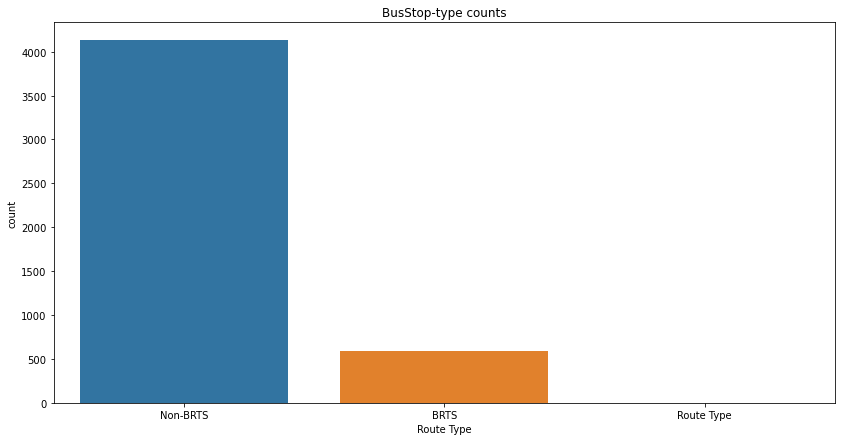

In [7]:
#lets see the count of bus stops labelled as BRT and non-BRT:
#there are duplicates so we'll introduce a new data set .
df_temp=pd.DataFrame()


for key,grp in route_name.groupby('Stop Name'):
    try:
        #most bus stops have stops on either side of the road so taking two values.
        ap=grp.iloc[:2]
    except:
        #some places (like bus depots) can have a single point as a Stop. 
        ap=grp.iloc[0]
    df_temp=df_temp.append(ap)


plt.figure(figsize=(14,7))    
sns.countplot(df_temp['Route Type'])
plt.title('BusStop-type counts')


# BRT BUS Stops.

In [8]:
#lets see the BRT stop locations clusters :

#making a Marker Cluster for visualization.
from folium.plugins import MarkerCluster

#pune map
Lat_mean=df_BRT['Latitude'].mean()
lon_mean=df_BRT['Longitude'].mean()

m_1 = folium.Map(location=[Lat_mean,lon_mean], tiles='Open Street Map', zoom_start=12,min_zoom=11)

#making a Marker Cluster for visualization.
mc=MarkerCluster().add_to(m_1)

#adding a extra tile layer.
# folium.TileLayer('cartodbpositron').add_to(m_1)
# folium.LayerControl().add_to(m_1)

for index,row in df_BRT.iterrows():
    location=[row['Latitude'],row['Longitude']]
    name=str(row['Stop Name'])
    if not math.isnan(location[0]) and not math.isnan(location[1]):
        mc.add_child(folium.Marker(location=location,tooltip=f'<b> {name} </b>'))
    else:
        pass
print('BRT Bus Stops.')
m_1.add_child(mc)

BRT Bus Stops.


**HeatMap for BRT Bus Stops.**

In [9]:
df_BRT.dropna(inplace=True)

#heatmap of BRT Bus stops:

m_2=folium.Map(location=[Lat_mean,lon_mean], tiles='Open Street Map', zoom_start=12,min_zoom=11)

folium.plugins.HeatMap(data=df_BRT[['Latitude','Longitude']],radius=10,opacity=.1).add_to(m_2)
print('BRT Bus stops Heatmap')
m_2

BRT Bus stops Heatmap


# Short Route Bus stops.

In [10]:
m_3 = folium.Map(location=[Lat_mean,lon_mean], tiles='Open Street Map', zoom_start=12,min_zoom=11)

#making a Marker Cluster for visualization.
mc=MarkerCluster().add_to(m_3)

for index,row in short_route_name.iterrows():
    location=[row['LAT'],row['LONG']]
    name=row['Stop Name']
    if not math.isnan(location[0]) and not math.isnan(location[1]):
        mc.add_child(folium.Marker(location=location,popup=f'<b> {name} </b>'))
    else:
        pass
for key,grp in short_route_name.groupby('Route'):
    folium.PolyLine(locations=grp[['LAT','LONG']], opacity=2, weight=2, tooltip=f'<b>{key}</b>').add_to(m_3)
print('Short route Bus stops')
m_3 

Short route Bus stops


In [11]:
short_route_name.dropna(inplace=True)

m_4=folium.Map(location=[Lat_mean,lon_mean], tiles='Open Street Map', zoom_start=12,min_zoom=10)
folium.plugins.HeatMap(data=short_route_name[['LAT','LONG']],radius=5,opacity=.1).add_to(m_2)
print('Short Route  Heatmap')
m_2

Short Route  Heatmap


In [12]:
#dropping Route 257-D and 8-U  from route name because they're showing anomalous data.
idx_to_drop=list(route_name[route_name['Route'] == '257-D'].index)
idx_to_drop.extend(route_name[route_name['Route']=='8-U'].index)
route_name.drop(idx_to_drop,inplace=True)

# All Bus stops and Routes.

In [13]:
m_5 = folium.Map(location=[Lat_mean,lon_mean], tiles='Open Street Map', zoom_start=12,min_zoom=10)

#making a Marker Cluster for visualization.
mc=MarkerCluster().add_to(m_5)

#dropping NA values in route_names:
route_name.dropna(inplace=True)

for key,grp in route_name.groupby('Stop Name'):
    location=[grp['LAT'].iloc[0],grp['LONG'].iloc[0]]
    name=key
    if not math.isnan(location[0]) and not math.isnan(location[1]):
        mc.add_child(folium.Marker(location=location,popup=f'<b> {name} </b>'))
    else:
        pass

# plotting a line through stops on the route:    
for key,grp in route_name.groupby('Route'):
    folium.PolyLine(locations=grp[['LAT','LONG']], opacity=2, weight=.5, tooltip=f'<b>{key}</b>').add_to(m_5)
print('Pune Bus Stops with route name')    
m_5 


Pune Bus Stops with route name


In [14]:
#Heatmap.
#df_temp created earlier.
df_temp.dropna(inplace=True)
    
m_6=folium.Map(location=[Lat_mean,lon_mean], tiles='Open Street Map', zoom_start=11,min_zoom=9)
folium.plugins.HeatMap(data=df_temp[['LAT','LONG']],radius=7,opacity=5).add_to(m_6)
print('All Bus stops Heatmap')
m_6

All Bus stops Heatmap


In [15]:
#creating a geopandas dataframe.

route_gdf=gpd.GeoDataFrame(route_name,geometry=gpd.points_from_xy(route_name['LONG'],route_name['LAT']),crs=4326)
# route_gdf.set_crs(epsg=3857)
#mercator
route_gdf['geometry'].to_crs(epsg=4326)

0        POINT (73.68818 18.57655)
1        POINT (73.68770 18.58102)
2        POINT (73.70010 18.58686)
3        POINT (73.70540 18.58899)
4        POINT (73.70821 18.59374)
                   ...            
34080    POINT (73.83321 18.53902)
34081    POINT (73.82702 18.54363)
34082    POINT (73.82808 18.54781)
34083    POINT (73.82473 18.55430)
34084    POINT (73.82232 18.55601)
Name: geometry, Length: 33933, dtype: geometry

In [16]:
route_gdf.reset_index(drop=True)

Route Type  Route Stop Code Stop Seq                         Stop Name  \
0           BRTS  100-D  100-D-01        1            Hinjawadi Maan Phase 3   
1           BRTS  100-D  100-D-02        2                     Tech Mahindra   
2           BRTS  100-D  100-D-03        3                       Tata Motors   
3           BRTS  100-D  100-D-04        4             Power House Hinjawadi   
4           BRTS  100-D  100-D-05        5                   Infosys Phase 2   
...          ...    ...       ...      ...                               ...   
33928   Non-BRTS  13C-U  13C-U-25       25                 Rangehills Corner   
33929   Non-BRTS  13C-U  13C-U-26       26  Pune Vidhyapeeth Gate Aundh Road   
33930   Non-BRTS  13C-U  13C-U-27       27                 Vidhyapeeth Press   
33931   Non-BRTS  13C-U  13C-U-28       28         Vidhyapeeth Main Building   
33932   Non-BRTS  13C-U  13C-U-29       29                  Pune Vidhyapeeth   

                Stop Name Marathi        LAT       LONG Stage Route_id  \
0               हिंजवडी माण फेज ३  18.576553  73.688178     1      100   
1                    टेक महेंद्रा  18.581016  73.687704     1      100   
2                     टाटा मोटर्स  18.586860  73.700098     2      100   
3               पॉवर हाऊस हिंजवडी  18.588990  73.705400     2      100   
4                  इन्फोसीस फेज 2  18.593741  73.708210     3      100   
...                           ...        ...        ...   ...      ...   
33928            रेंजहिल्स कॉर्नर  18.539017  73.833213     8      13C   
33929  पुणे विद्यापीठ गेट औंध रोड  18.543632  73.827019     9      13C   
33930             विद्यापीठ प्रेस  18.547810  73.828080     9      13C   
33931      विद्यापीठ मेन बिल्डिंग  18.554300  73.824730     9      13C   
33932              पुणे विद्यापीठ  18.556015  73.822317    10      13C   

                        geometry  
0      POINT (73.68818 18.57655)  
1      POINT (73.68770 18.58102)  
2      POINT (73.70010 18.58686)  
3      POINT (73.70540 18.58899)  
4      POINT (73.70821 18.59374)  
...                          ...  
33928  POINT (73.83321 18.53902)  
33929  POINT (73.82702 18.54363)  
33930  POINT (73.82808 18.54781)  
33931  POINT (73.82473 18.55430)  
33932  POINT (73.82232 18.55601)  

[33933 rows x 11 columns]

# Function to calculate closest bus stop.

In [17]:
# lat_conv=110.574 #km
# long_conv=111.320 * np.cos(lat)

# Point.
from shapely.geometry import Point

#for displaying the map
from IPython.display import HTML,display


def closest_Bus_stop(lat,long):
    point=Point(long,lat)
    min_idx=np.argmin(route_gdf.geometry.distance(point))
#     min_idx=route_gdf.geometry.distance((point)).idxmin
    
    #finding the closest bus stop.
    bs=route_gdf.iloc[min_idx]
    name=bs['Stop Name']
    dis=np.sqrt((abs(lat-bs['LAT'])*110.574)**2 + ((abs(long-bs['LONG'])*(111.320)*np.cos(lat))**2))      #aerial distance
    
    
    #plotting the map and the points.
    m=folium.Map(location=[lat,long], tiles='Open Street Map', zoom_start=13,min_zoom=9)
    folium.Marker(location=[lat,long],tooltip=f'<b> Current Location </b>',icon=folium.Icon(color='blue',icon='home')).add_to(m)
    folium.Marker(location=[bs['LAT'],bs['LONG']],tooltip=f'<b> {name} </b>',icon=folium.Icon(color='green',icon='info-sign')).add_to(m)
    
    
    print(f'{name} is {dis} km away.')
    display(m)

In [18]:
closest_Bus_stop(18.5216668,73.8296012)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  del sys.path[0]


Symbiosis College is 0.059986136987301035 km away.


# Function to calculate closest  Bus stop to current location and Destination and distances.

In [19]:
#using the fuction we build,lets build a funtion to find the best bus travel option between two points:

def bus_route(start,des):
    #point objects.
    start_p=Point(start)
    des_p=Point(des)
    
    # indexes of closest stops to the starting point and end point:
    route_gdf['geometry'].to_crs(epsg= 4326)
    srt_idx=np.argmin(route_gdf.geometry.distance(start_p))
    des_idx=np.argmin(route_gdf.geometry.distance(des_p))
    
    #Closest stops
    start_bs=route_gdf.iloc[srt_idx]
    des_bs=route_gdf.iloc[des_idx]
    #stop name;
    s_name=start_bs['Stop Name']
    des_name=des_bs['Stop Name']
    
    
    #distance between bus stops and locations
      #start location to closest bus stop
    dis1=np.sqrt((abs(start[1]-start_bs['LAT'])*110.574)**2 + ((abs(start[0]-start_bs['LONG'])*(111.320)*np.cos(np.mean([start[1],des[1]]))**2)))      #aerial distance
    
    
      #destination bus stop to destination
    dis2=np.sqrt((abs(des[1]-des_bs['LAT'])*110.574)**2 + ((abs(des[0]-des_bs['LONG'])*(111.320)*np.cos(np.mean([start[1],des[1]]))**2)))      #aerial distance
    
    #MAP
    m=folium.Map(location=[np.mean([start[1],des[1]]),np.mean([start[0],des[0]])],min_zoom=9,tiles='Open Street Map',zoom_start=12)
    
    #Markers.
        #start_location:
    folium.Marker(location=(start[1],start[0]),tooltip='Current Location').add_to(m)
    
        #destination
    folium.Marker(location=(des[1],des[0]),tooltip='Destination',icon=folium.Icon(color='black',icon='stop')).add_to(m)
    
        #bus stops
    folium.Marker(location=(start_bs.LAT,start_bs.LONG),icon=folium.Icon(color='green',icon='info-sign'),tooltip=f'{s_name}').add_to(m)
    folium.Marker(location=(des_bs.LAT,des_bs.LONG),icon=folium.Icon(color='darkgreen',icon='info-sign'),tooltip=f'{des_name}').add_to(m)
    
    print(f'Current location to {s_name} is {dis1} km.  \n  {des_name} to Destination is {dis2} km.')
    
    display(m)
    

In [20]:
bus_route((73.8858491,18.4632745),(73.8354001,18.5234569))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  # This is added back by InteractiveShellApp.init_path()


Current location to Kondhwa Police Station is 0.5965681083373091 km.  
  Pandavnagar Senapati Bapat Road to Destination is 0.48682105792452895 km.
